In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak
import pickle

In [2]:
file = "/home/dejavu/Projects/qgcal/Training/dijet_sample_newBDT_flatten.npy"
all_jets = np.load(file)
all_jets[:, 0] = all_jets[:, 0]/1e3

## inclusive jet pt

In [3]:
all_jets.shape # Flatten events, need to reshape to split for leading/eta 

(72778406, 9)

In [7]:
def split_jet_type(jets):
    gluon_idx = np.where(jets[:,6]==21)[0]
    light_quark_idx = np.where((jets[:,6]==1) | (jets[:,6]==2)| (jets[:,6]==3))[0]
    c_quark_idx = np.where(jets[:,6]==4)[0]
    b_quark_idx = np.where(jets[:,6]==5)[0]
    data_idx = np.where(jets[:,6]==-9999)[0]
    others_idx = np.where(jets[:,6]==-1)[0]

    gluon = jets[gluon_idx]
    quark = jets[light_quark_idx]
    c_quark = jets[c_quark_idx]
    b_quark = jets[b_quark_idx]
    data = jets[data_idx]
    others = jets[others_idx]

    return [gluon, quark, c_quark, b_quark, data, others]

In [8]:
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1",
                "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight", "newBDTScore"]

array([ 5.13987344e+02, -1.06735952e-01,  2.30000000e+01,  5.60825728e-02,
        2.49986455e-01,  1.75032362e-01,  2.10000000e+01,  1.00000000e+00,
        3.04279175e-01])

In [11]:
def Draw_ROC(y, decisions, y_tmva, y_ntrk, X_weight, title_pt="Inclusive", save=True):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))
    plt.xticks(np.linspace(0, 1., 11))
    plt.yticks(np.linspace(0, 1., 21))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'ROC with jet $p_T$: ' + f"{title_pt}")
    plt.legend(loc="lower left")
    plt.grid()
    if save:
        plt.savefig(f"plots_ROC/ROC_pt{title_pt}")
    
    plt.show()


In [43]:
splited_all_jets_types = split_jet_type(all_jets)
X = np.concatenate((splited_all_jets_types[1], splited_all_jets_types[0]), axis=0)
y = np.concatenate((np.zeros(len(splited_all_jets_types[1])), 1.0 * np.ones(len(splited_all_jets_types[0]))))
Draw_ROC(y = y, decisions=X[:,8], y_tmva=X[:,5], y_ntrk=X[:,2], X_weight=X[:,7], title_pt="Inclusive")


## split jet pt

In [45]:
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
def split_jet_pt(jets):
    splited_jet_pt = {}
    for i, pt_start in enumerate(label_pt_bin[:-1]):
        pt_selected_idx = np.where((jets[:,0] >= pt_start) & (jets[:,0] < label_pt_bin[i+1]))[0]
        splited_jet_pt[pt_start] = jets[pt_selected_idx]

    return splited_jet_pt

In [46]:
splited_jet_pt = split_jet_pt(all_jets)

pt500 : num_jets 20926320


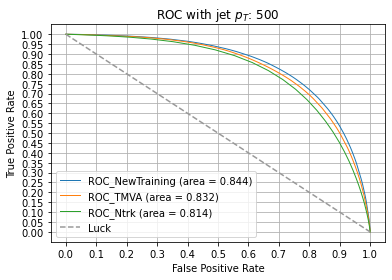

pt600 : num_jets 22210614


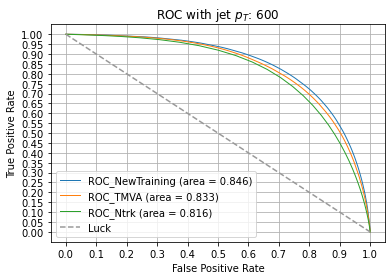

pt800 : num_jets 6858240


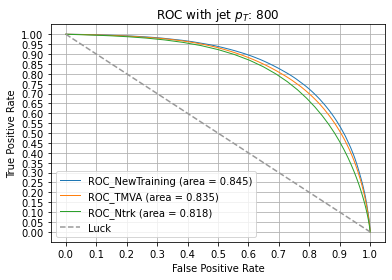

pt1000 : num_jets 3841494


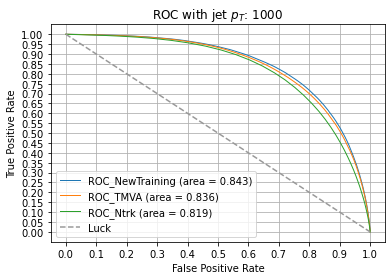

pt1200 : num_jets 4852847


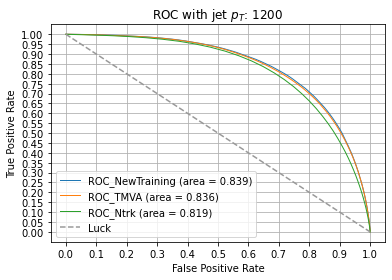

pt1500 : num_jets 5164032


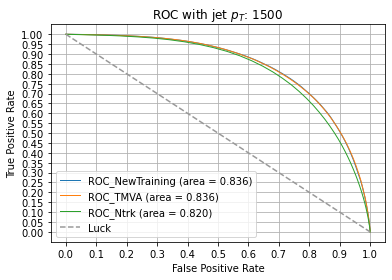

AssertionError: 

In [65]:
sum = 0
for k, splited_jet_pt_bin in splited_jet_pt.items():
    print(f"pt{k} : num_jets {len(splited_jet_pt_bin)}")
    sum += len(splited_jet_pt_bin)
    splited_pt_jets_types = split_jet_type(splited_jet_pt_bin)
    
    X = np.concatenate((splited_pt_jets_types[1], splited_pt_jets_types[0]), axis=0)
    y = np.concatenate((np.zeros(len(splited_pt_jets_types[1])), 1.0 * np.ones(len(splited_pt_jets_types[0]))))
    Draw_ROC(y = y, decisions=X[:,8], y_tmva=X[:,5], y_ntrk=X[:,2], X_weight=X[:,7], title_pt=k)


assert sum == len(all_jets)

## test < 500GeV

In [9]:
lt500_jets = all_jets[np.where(all_jets[:,0] < 500)]

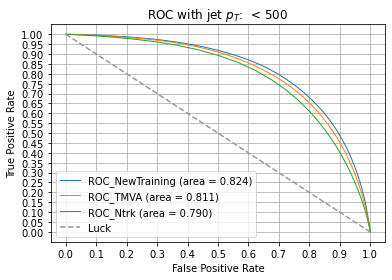

In [12]:
splited_lt500_jets_types = split_jet_type(lt500_jets)
X = np.concatenate((splited_lt500_jets_types[1], splited_lt500_jets_types[0]), axis=0)
y = np.concatenate((np.zeros(len(splited_lt500_jets_types[1])), 1.0 * np.ones(len(splited_lt500_jets_types[0]))))
Draw_ROC(y = y, decisions=X[:,8], y_tmva=X[:,5], y_ntrk=X[:,2], X_weight=X[:,7], title_pt=" < 500")


In [13]:
len(all_jets)

72778406

In [67]:
sum

63853547

In [72]:
len(np.where(all_jets[:,0] < 500)[0]) + sum

72778406

In [74]:
len(np.where(all_jets[:,0] < 500)[0]) / len(all_jets)

0.12263059182692185

In [48]:
np.max(all_jets[:,0])

1999.999875

## test subset

In [49]:
splited_all_jets_types = split_jet_type(all_jets)

In [ ]:
splits = np.linspace(0,1,11) *  len(all_jets)
for split in splits[1:]:
    
    splited_pt_jets_types = split_jet_type(all_jets[:int(split)])
    
    X = np.concatenate((splited_pt_jets_types[1], splited_pt_jets_types[0]), axis=0)
    y = np.concatenate((np.zeros(len(splited_pt_jets_types[1])), 1.0 * np.ones(len(splited_pt_jets_types[0]))))
    Draw_ROC(y = y, decisions=X[:,8], y_tmva=X[:,5], y_ntrk=X[:,2], X_weight=X[:,7], title_pt=split, save = False)

## split leading/subleading, central/forward

In [22]:
all_jets_event = np.reshape(all_jets, (len(all_jets)//2,2,9))

In [15]:
label_pt = ["LeadingJet", "SubJet"]
label_eta = ["Forward", "Central"]
label_type = ["Gluon", "Quark", "C_Quark", "B_Quark", "Data", "Other"]
label_var = ["pt", "eta", "ntrk", "width", "c1", "bdt", "newBDT"]
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]

In [23]:
all_jets_event.shape

(36389203, 2, 9)

In [35]:
def Draw_ROC_splited(y, decisions, y_tmva, y_ntrk, X_weight, prefix, title_pt="Inclusive", save=True):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))
    plt.xticks(np.linspace(0, 1., 11))
    plt.yticks(np.linspace(0, 1., 21))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'ROC with jet $p_T$: ' + f"{title_pt} in {prefix}")
    plt.legend(loc="lower left")
    plt.grid()
    if save:
        plt.savefig(f"plots_ROC/ROC_{prefix}_pt{title_pt}")
    
    plt.show()


In [17]:
def split_pt_eta_jet(jets):
    # divide jets into 4 regions 
    forward_idx = np.argmax(np.abs(jets[:,:,1]), axis=1) # compare abs eta of jets inside events
    central_idx = -1*forward_idx+1

    leading_forward_idx = forward_idx == 0 # leading forward 
    subleading_forward_idx = forward_idx == 1 # subleading forward 

    leading_central_idx = central_idx == 0 # leading central 
    subleading_central_idx = central_idx == 1 # subleading central 

    return [jets[leading_forward_idx, 0, :], jets[leading_central_idx, 0, :],  
            jets[subleading_forward_idx, 1, :], jets[subleading_central_idx, 1, :]]

def split_jet_type(jets):
    gluon_idx = np.where(jets[:,6]==21)[0]
    light_quark_idx = np.where((jets[:,6]==1) | (jets[:,6]==2)| (jets[:,6]==3))[0]
    c_quark_idx = np.where(jets[:,6]==4)[0]
    b_quark_idx = np.where(jets[:,6]==5)[0]
    data_idx = np.where(jets[:,6]==-9999)[0]
    others_idx = np.where(jets[:,6]==-1)[0]

    gluon = jets[gluon_idx]
    quark = jets[light_quark_idx]
    c_quark = jets[c_quark_idx]
    b_quark = jets[b_quark_idx]
    data = jets[data_idx]
    others = jets[others_idx]

    return [gluon, quark, c_quark, b_quark, data, others]

def split_jet_pt(jets):
    splited_jet_pt = {}
    for i, pt_start in enumerate(label_pt_bin[:-1]):
        pt_selected_idx = np.where((jets[:,0] >= pt_start) & (jets[:,0] < label_pt_bin[i+1]))[0]
        splited_jet_pt[pt_start] = jets[pt_selected_idx]

    return splited_jet_pt


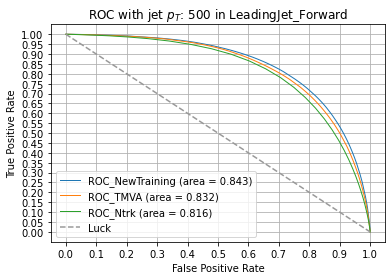

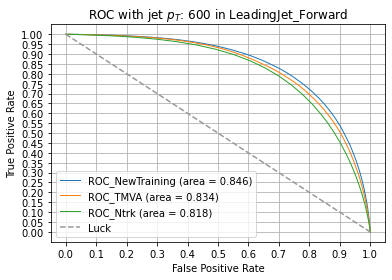

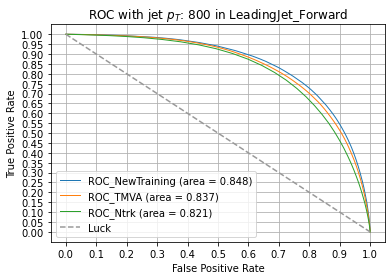

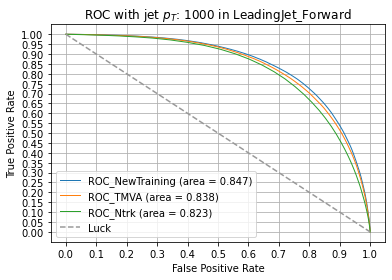

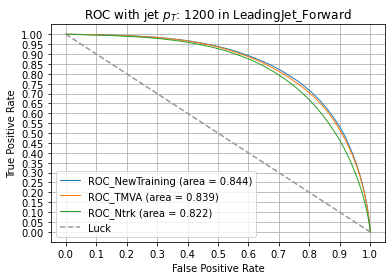

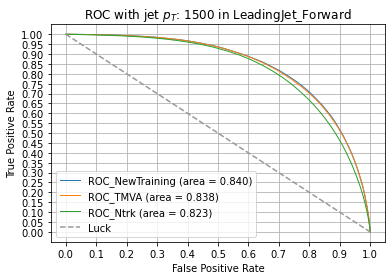

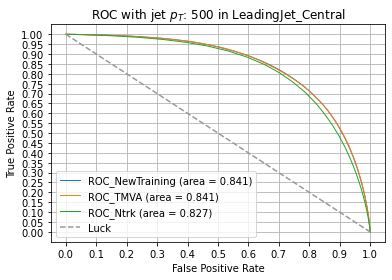

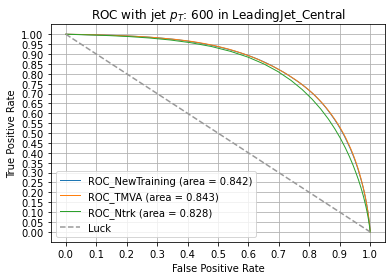

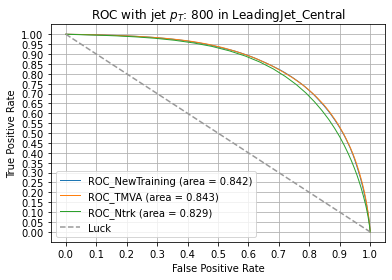

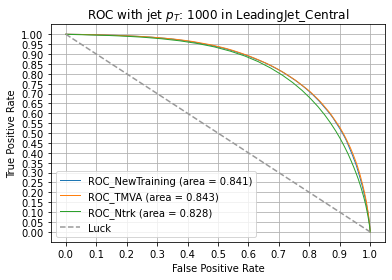

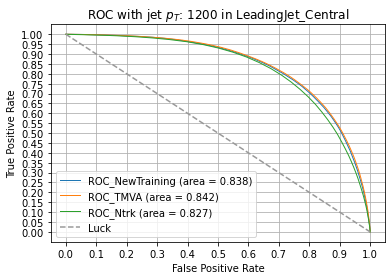

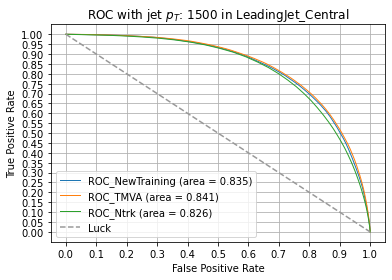

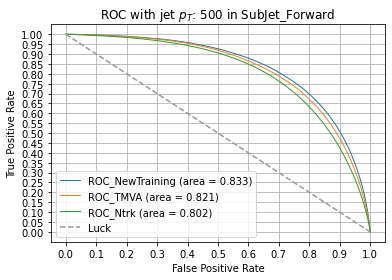

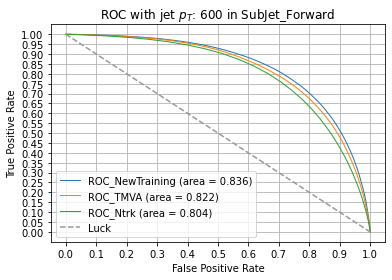

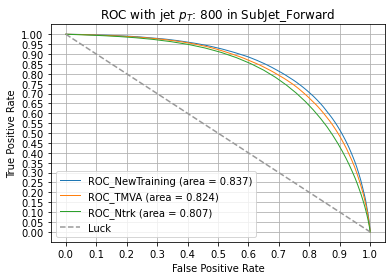

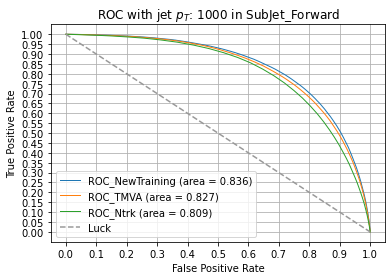

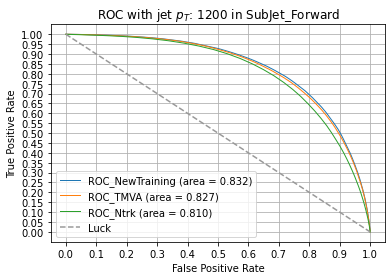

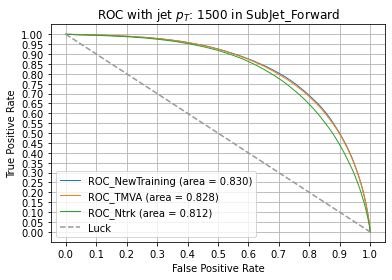

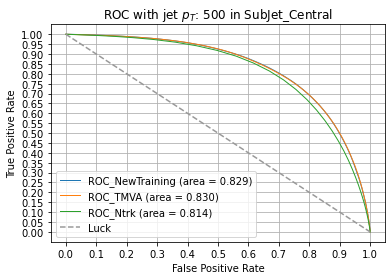

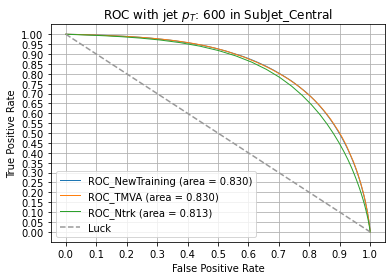

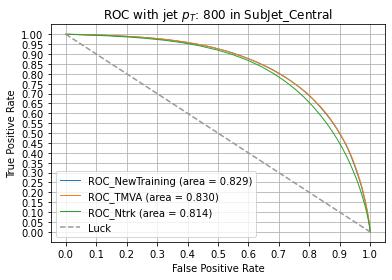

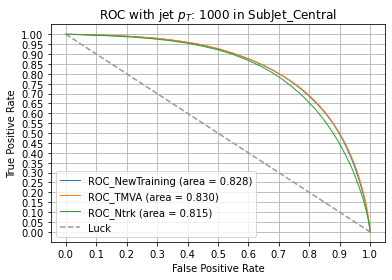

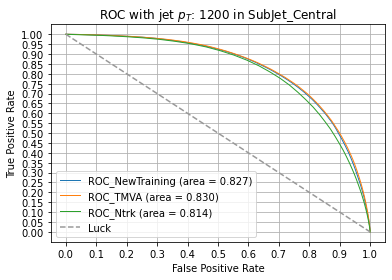

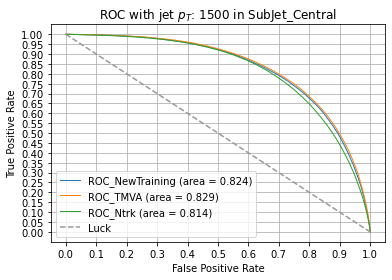

In [36]:
splited_pt_eta_jets = split_pt_eta_jet(all_jets_event)
label_pt_eta = [label1_pt + "_" + label2_eta for label1_pt in label_pt for label2_eta in label_eta]
label_type = ["Gluon", "Quark", "C_Quark", "B_Quark", "Data", "Other"]

n_jets = 0
for i, splited_pt_eta_jet in enumerate(splited_pt_eta_jets):
    n_jets += len(splited_pt_eta_jet)

    splited_pt_eta_pt_bins = split_jet_pt(splited_pt_eta_jet)
    for j, splited_pt_eta_pt_bin in splited_pt_eta_pt_bins.items():
        splited_pt_eta_jets_types = split_jet_type(splited_pt_eta_pt_bin)

        X = np.concatenate((splited_pt_eta_jets_types[1], splited_pt_eta_jets_types[0]), axis=0)
        y = np.concatenate((np.zeros(len(splited_pt_eta_jets_types[1])), 1.0 * np.ones(len(splited_pt_eta_jets_types[0]))))
        Draw_ROC_splited(y = y, decisions=X[:,8], y_tmva=X[:,5], y_ntrk=X[:,2], X_weight=X[:,7], prefix =  label_pt_eta[i], title_pt=j, save = True)
            
            

assert n_jets == len(all_jets_event)*2 # Check if jets are splited correctly 

In [49]:
def Draw_ROC_2(y, decisions, y_tmva, y_ntrk, X_weight, title_pt="Inclusive"):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    # this is good for only calulate the score withou visualization
    roc_auc = roc_auc_score(y, decisions, sample_weight = X_weight)
    roc_auc_tmva = roc_auc_score(y, y_tmva, sample_weight = X_weight)
    roc_auc_ntrk = roc_auc_score(y, y_ntrk, sample_weight = X_weight)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'ROC with jet $p_T$: ' + f"{title_pt}")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


In [ ]:
bdt_axis = np.linspace(-0.8, 0.7, 60 )
plt.hist(splited_pt_eta_jets_types[0][:,-1], 
        weights=splited_pt_eta_jets_types[0][:,-2], 
        bins= bdt_axis, alpha=0.5, 
        label='gluon'+f"_num: {len(splited_pt_eta_jets_types[0])}", color = 'blue') 
plt.hist(splited_pt_eta_jets_types[1][:,-1], 
        weights=splited_pt_eta_jets_types[1][:,-2], 
        bins= bdt_axis, alpha=0.5, 
        label='quark'+f"_num: {len(splited_pt_eta_jets_types[1])}", color = 'red')
plt.legend(loc='upper left')

plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New BDT response(inclusive jet $p_T$)")
plt.savefig("plots_newTrainingPythia/BDT_dist_allpt")
plt.show()

In [4]:
all_jets = np.reshape(all_jets, (len(all_jets)//2,2,9))

In [6]:
branch_names = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "total_weight", "newBDTScore"]